<a href="https://colab.research.google.com/github/MohamedMohana/OpenCV/blob/master/Off%20%26%20Realt-Time%20Face%20Recognition%20Using%20OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Off-Time Face Recognition **

# Import The Library


In [6]:
# To read data directories and paths from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Used only with Colab instead of cv2.imshow()
from google.colab.patches import cv2_imshow 

# OpenCV Library
import cv2

# Numpy library 
import numpy as np

# To read directories
import os

# Data

The data was collected manually from google for the following actors:
* Aamir Khan | Face1
* Amitabh Bachchan | Face2
* Will Smith | Face3
* Other unknown pictures to support the results | Face4

OpenCV face recognizer accepts only labels as integers so we need to define a mapping between integer labels and persons actual names.

We need to define a mapping of persons integer labels and their respective names.

In [0]:
# Since we have not assigned label 0 to any person so the mapping for label 0 is empty
subjects = ['','Aamir Khan', 'Amitabh Bachchan', 'Will Smith', 'unknown']

# Creating functions to help us

We will start by creating a function to detect faces using the library OpenCV


In [0]:
def detect_face(img):
    # Convert the image to gray image as opencv face detector expects only a gray images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # OpenCV pre-trained model to detect the faces, you can use lbpcascade_frontalface OR haarcascade_frontalface
    face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/OpenCV_Model/lbpcascade_frontalface.xml')

    # To detect multiscale images | scaleFactor & minNeighbors choose base on try and error
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5);
    
    # If no faces are detected, return original image
    if (len(faces) == 0):
        return None, None
    
    # Under the assumption that there will be only one face, extract the face area
    (x, y, w, h) = faces[0]
    
    # Return only the face part of the image
    return gray[y : y+w, x : x+h], faces[0]

Function to draw rectangle on image 
* cv2.rectangle(img, topLeftPoint, bottomRightPoint, rgbColor, lineWidth)

In [0]:
# According to given (x, y) coordinates and given width and heigh
def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2) #Red 

Function to draw text on give image 
* cv2.putText(img, text, startPoint, font, fontSize, rgbColor, lineWidth)

In [0]:
def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 255), 2) 

Applying the algorith on the original images takes a huge time, So it is always better to resize the images to speed up the process, and this is going to be done by this function

In [0]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):

    # Initialize the dimensions of the image to be resized and grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # If both the width and height are None, then return the original image
    if width is None and height is None:
        return image

    # Check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # Otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # Return the resized image
    return resized

We will create another function to load the traning data and return a list of faces and a list of labels for each face

In [0]:
def training_data(data_path):
    
    # Starting by getting the directories in data folder
    dirs = os.listdir(data_path)
    
    # Create a list to hold all subject faces
    faces = []
    # Create a list to hold labels for all subjects
    labels = []
    
    # To go through each directory and read images within it
    for dir_name in dirs:
        
        # The Faces directories started with the word 'Face' | Ignore any non-relevant directories if any
        if not dir_name.startswith('Face'):
            continue;
            
        # Now extract label number of faces as remove 'Face' from dir_name will give us label
        label = int(dir_name.replace("Face", ""))
        
        # Build path of directory containin images for current subject sample | faces_dir_path = "training-data/Face1"
        faces_dir_path = data_path + "/" + dir_name
        
        # Get the images names that are inside the given subject directory
        subject_images_names = os.listdir(faces_dir_path)
        
        # Lastly, go through each image name, read image, detect face and add face to list of faces
        for image_name in subject_images_names:
            
            # Ignore system files like .DS_Store (For Mac users)
            if image_name.startswith("."):
                continue;
            
            # Build the image path sample | image path = training/Face1/00000000.jpg
            image_path = faces_dir_path + "/" + image_name

            # Read image
            original_image = cv2.imread(image_path)

            # Resize image | 200x200
            image = image_resize(original_image, width = 200, height = 200)
            
            # Display an image window to show the image 
            cv2_imshow(image)
            cv2.waitKey(100)
            
            # Detect faces
            face, rect = detect_face(image)
            
            # We will ignore faces are not detected
            if face is not None:
                # Add face to list of faces
                faces.append(face)
                # Add label for this face
                labels.append(label)

    return faces, labels

Function to recognizes the person in image passed and draws a rectangle around detected face with name of the subject

In [0]:
def predict(test_img):

    # Make a copy of the image as we don't want to chang original image
    img = test_img.copy()

    # Detect face from the image
    face, rect = detect_face(img)

    # Predict the image using our face recognizer 
    label= face_recognizer.predict(face)

    # Get name of respective label returned by face recognizer
    label_text = subjects[label[0]]
    
    # Draw a rectangle around face detected
    draw_rectangle(img, rect)

    # Draw name of predicted person
    draw_text(img, label_text, rect[0], rect[1]-5)
    
    return img

#Now it is time to use some of these functions on our data to prepare it for training of our face recognizer 

In [0]:
# Prepare our training data as data will be in two lists of same size
# one list will contain all the faces and other list will contain respective labels for each face
print("...............Preparing data...............")
faces, labels = training_data('/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/Training')
print("Data prepared")

# Print total faces and labels
print("Total faces: ", len(faces))
print("Total labels: ", len(labels))

#Train Face Recognizer

OpenCV comes with three face recognizers.

* EigenFace Recognizer
* FisherFace Recognizer:
* Local Binary Patterns Histogram (LBPH)

You should try them one by one and know one would produce the highest accuracy 

In [0]:
# Create LBPH face recognizer 
face_recognizer = cv2.face.LBPHFaceRecognizer_create()


# Create EigenFaceRecognizer
#face_recognizer = cv2.face.EigenFaceRecognizer_create() # Resize the image to 28x28 in here

# Create FisherFaceRecognizer 
#face_recognizer = cv2.face.FisherFaceRecognizer_create() # Resize the image to 28x28 in here

In [0]:
# Train our face recognizer of our training faces
face_recognizer.train(faces, np.array(labels)) # OpenCV expects labels vector to be a numpy array.

# Fun Part | Prediction

...............Predicting images...............
Prediction complete


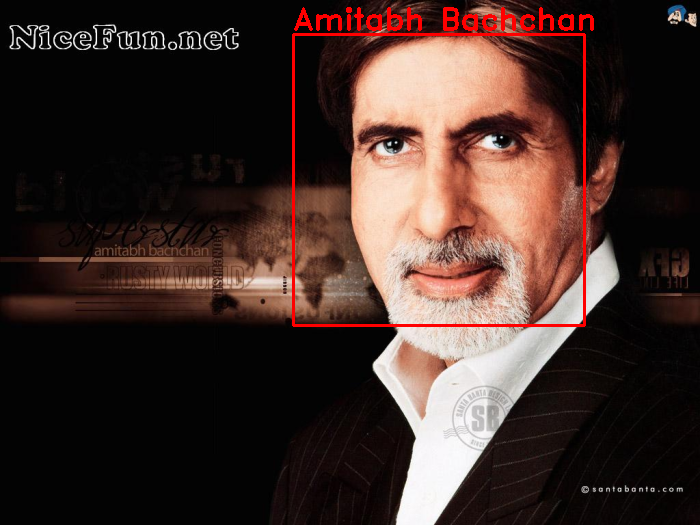

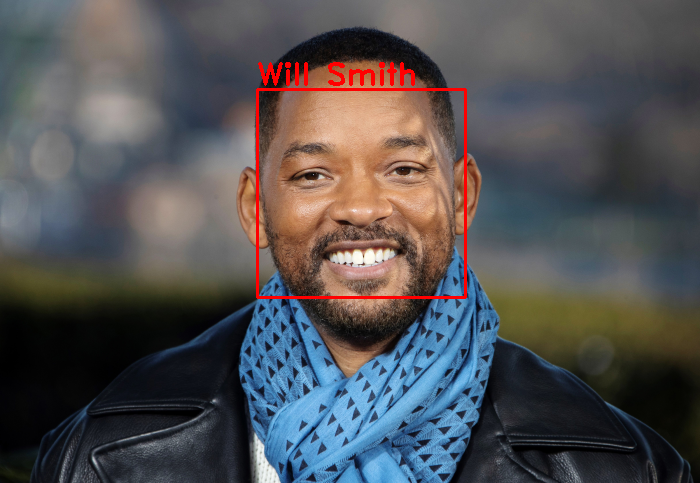

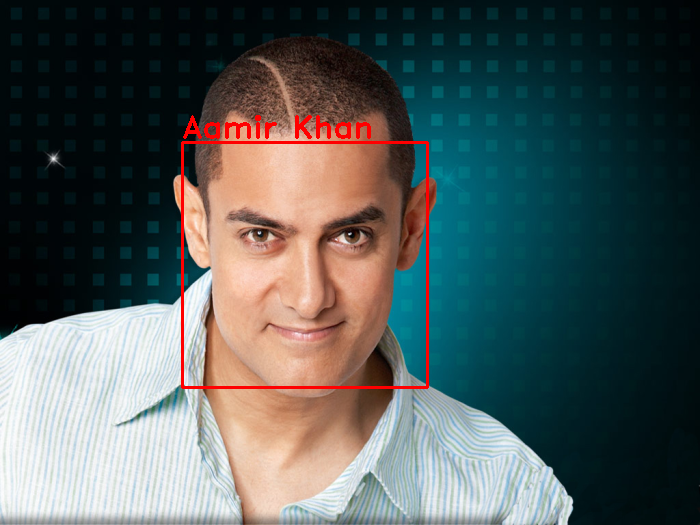

In [0]:
print("...............Predicting images...............")

#load test images & Resize it 
test1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/Testing/000000021.jpg')
test11 = image_resize(test1, width = 700, height = 700)
test2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/Testing/2.jpg')
test22 = image_resize(test2, width = 700, height = 700)
test3 = cv2.imread('/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/Testing/3.jpg')
test33 = image_resize(test3, width = 700, height = 700)

#perform a prediction
predicted_img1 = predict(test11)
predicted_img2 = predict(test22)
predicted_img3 = predict(test33)


print("Prediction complete")

#display both images
cv2_imshow(predicted_img1)
cv2_imshow(predicted_img2)
cv2_imshow(predicted_img3)

#  **Real-Time Face Recognition **

#Import The Library

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
from PIL import Image
import io
import cv2

# Turn On the webcam using Colab


In [0]:
def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }


    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x




# Testing the face detection using the webcam

In [0]:

VideoCapture()
eval_js('create()')


# Create the haar cascade
face_detector = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/OpenCV_Model/lbpcascade_frontalface.xml')

while True:
  	# Capture frame-by-frame
    byte = eval_js('capture()')
    im = byte2image(byte)

  	# Our operations on the frame come here
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

  	# Detect faces in the image
    faces = face_detector.detectMultiScale(gray, 1.1, 4)

	 # Draw a rectangle around the faces
    for(x, y, w, h) in faces:
      cv2.rectangle(im, (x,y), (x+w,y+h), (255,0,0), 2)

 	# Display the resulting frame
    eval_js('showimg("{}")'.format(image2byte(im)))  

# Let's get important pre-trained models

1-  Landmark’s facial detector 


In [3]:
!wget https://github.com/AKSHAYUBHAT/TensorFace/raw/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat

--2020-04-07 13:27:26--  https://github.com/AKSHAYUBHAT/TensorFace/raw/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AKSHAYUBHAT/TensorFace/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat [following]
--2020-04-07 13:27:26--  https://raw.githubusercontent.com/AKSHAYUBHAT/TensorFace/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[======

2 - Pre-trained models for face recognition. 

In [4]:
!wget https://github.com/ageitgey/face_recognition_models/raw/master/face_recognition_models/models/dlib_face_recognition_resnet_model_v1.dat

--2020-04-07 13:27:32--  https://github.com/ageitgey/face_recognition_models/raw/master/face_recognition_models/models/dlib_face_recognition_resnet_model_v1.dat
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageitgey/face_recognition_models/master/face_recognition_models/models/dlib_face_recognition_resnet_model_v1.dat [following]
--2020-04-07 13:27:32--  https://raw.githubusercontent.com/ageitgey/face_recognition_models/master/face_recognition_models/models/dlib_face_recognition_resnet_model_v1.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22466066 (21M) [application/octet-stream]
Saving to: 

# Face extraction 


Note: 
* Create A folder with the name ***facedata*** and put one piture for each person such as **Mohana_1.jpg , Mohd_2.jpg** and so on

In [16]:
# Face extraction 

import numpy as np, cv2, dlib, os, pickle

path = '/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/facedata/'

detector = dlib.get_frontal_face_detector()

sp = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

model = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

FACE_DESC = []
FACE_NAME = []

for fn in os.listdir(path):
    if fn.endswith('.jpg'):
        img = cv2.imread(path + fn)[:,:,::-1]
        dets = detector(img, 1)
        for k, d in enumerate(dets):
            shape = sp(img, d)
            face_desc = model.compute_face_descriptor(img, shape, 100)
            FACE_DESC.append(np.array(face_desc))
            print('loading...', fn)
            FACE_NAME.append(fn[:fn.index('_')])
pickle.dump((FACE_DESC, FACE_NAME), open('trainset.pk', 'wb'))

loading... mohana_1.jpg
loading... sami_1.jpg
loading... will Smith_1.jpg
loading... aamirkhan_1.jpg


# Fun Part | Real-Time Face Recognition

In [0]:
face_detector = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/OpenCV_Model/lbpcascade_frontalface.xml')
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
model = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')
FACE_DESC, FACE_NAME = pickle.load(open('trainset.pk', 'rb'))

# These 2 instead of | cap = cv2.VideoCapture(0)
VideoCapture()
eval_js('create()')

while True:

    # These 2 instead of | _, frame = cap.read()
    byte = eval_js('capture()')
    frame = byte2image(byte)

    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = face_detector.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        img = frame[y-10:y+h+10, x-10:x+w+10][:,:,::-1]
        dets = detector(img, 1)
        for k, d in enumerate(dets):
            shape = sp(img, d)
            face_desc0 = model.compute_face_descriptor(img, shape, 1)
            d = []
            for face_desc in FACE_DESC:
                d.append(np.linalg.norm(np.array(face_desc) - np.array(face_desc0)))
            d = np.array(d)
            idx = np.argmin(d)
            if d[idx] < 0.5:
                name = FACE_NAME[idx]
                #print(name)
                cv2.putText(frame, name, (x, y-5), cv2.FONT_HERSHEY_COMPLEX, .7, (255,255,255),2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # This 1 instead of | cv2.imshow('frame', frame)       
    eval_js('showimg("{}")'.format(image2byte(frame)))

Results

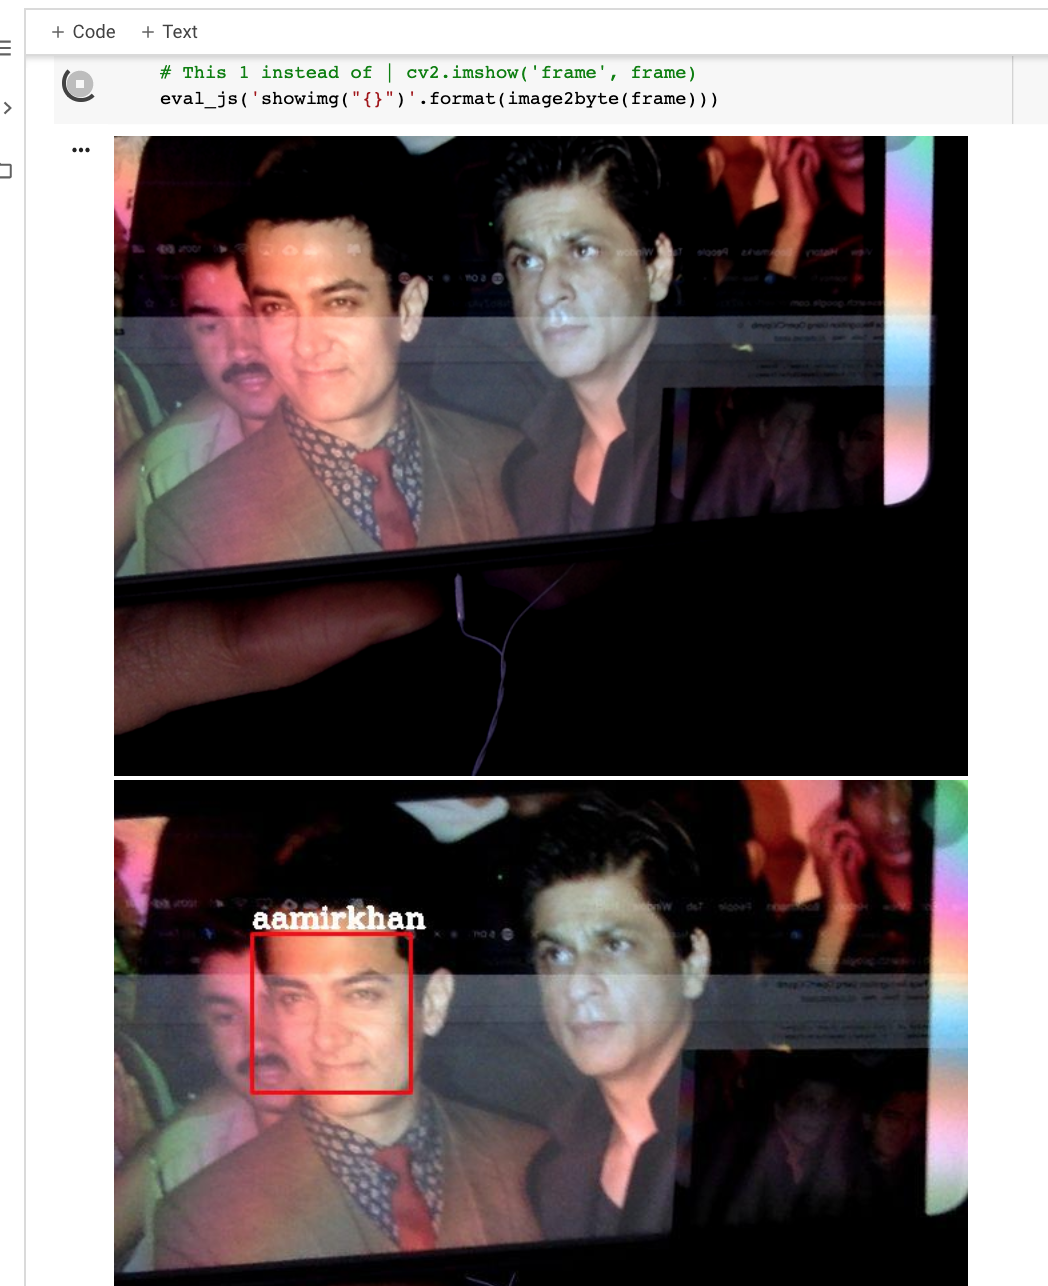

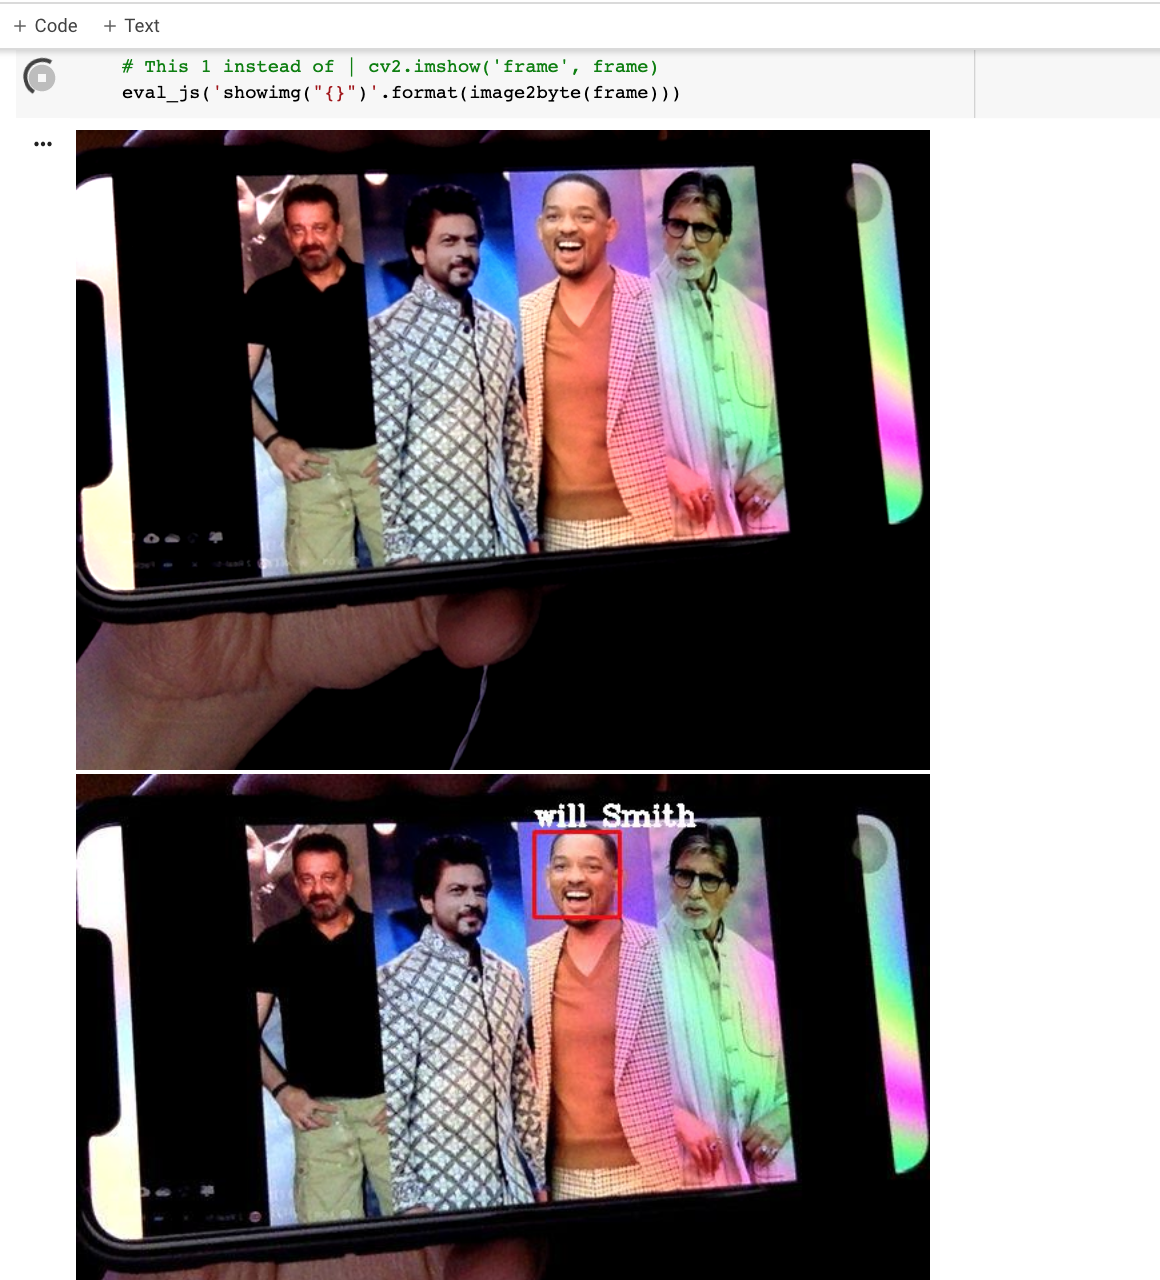

In [19]:
import cv2
from google.colab.patches import cv2_imshow

Reult1 = '/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/Result_Real_Time/Result1.png'
Reult2 = '/content/drive/My Drive/Colab Notebooks/AI Boot Camp CV/Project/Result_Real_Time/Result2.png'

image_Reult1 = cv2.imread(Reult1)
image_Reult2 = cv2.imread(Reult2)

cv2_imshow(image_Reult1)
cv2_imshow(image_Reult2)